<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Generate a Network Model Grid on an OpenTopography DEM
<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>

<hr>

This notebook demonstrates how to create a NetworkModelGrid from a DEM hosted by OpenTopography. In this tutorial we will:
* Download a DEM from OpenTopography
* Reproject the DEM into a meter-based coordinate system (UTM-13)
* Clip the DEM to the largest watershed
* Create a NetworkModelGrid on the river system in this watershed using three different 'network_grid_from_raster' options

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from landlab import imshow_grid

## 1. Download DEM from OpenTopography using Topography utility

Create a function to download and save SRTM images using  [BMI_topography](https://bmi-topography.readthedocs.io/en/latest/).
* From: 
https://github.com/landlab/landlab/blob/master/notebooks/tutorials/flow_direction_and_accumulation/PriorityFlood_realDEMs.ipynb

In [2]:
from bmi_topography import Topography

Download (or reload) topography data.

In [3]:
width = 0.02
height = 0.02
dem = Topography(
    north=40.03 + height,
    south=40.01 - height,
    east=-105.32 + width,
    west=-105.4 - width,
    output_format="AAIGrid",
    dem_type="SRTMGL3",
)
_ = dem.load()

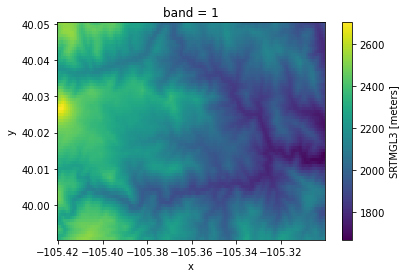

In [4]:
dem.load().plot()

## 2. Use Rasterio to Reproject DEM

Use rasterio to reproject to UTM Zone 13. Since our DEM was pulled from the CO region, this is the appropriate UTM system, but you can specify a general EPSG code as 'dst_crs' if you wish to reproject to a different area.
* reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.calculate_default_transform

In [5]:
import rasterio
from rasterio.warp import calculate_default_transform, Resampling

In [6]:
src_crs = "EPSG:4326"  # Source coordinate system (by default, open_topo BMI loads in WGS84 lat/lon)
dst_crs = "EPSG:32613"  # Set a destination coordinate system

This is the resolution in meters of our target DEM, the UTM coordinate system has a native unit of meters.

In [7]:
target_res = 50

transform, dim_x_transf, dim_y_transf, = calculate_default_transform(
    src_crs,
    dst_crs,
    len(dem.da["x"]),
    len(dem.da["y"]),
    left=dem.bbox.west,
    bottom=dem.bbox.south,
    right=dem.bbox.east,
    top=dem.bbox.north,
    resolution=target_res,
)

Let's use this transform to get X and Y vectors along the DEM row=0 and col=0 lines respectively so we know what new x, y coordinates to assign to our transformed `DataArray`.

In [9]:
# x_UTM13, _ = rasterio.transform.xy(transform, 0, np.arange(0, dim_x_transf, 1))
# _, y_UTM13 = rasterio.transform.xy(transform, np.arange(0, dim_y_transf, 1), 0)

x_UTM13, _ = rasterio.transform.xy(transform, np.zeros(dim_x_transf), np.arange(0, dim_x_transf, 1))
_, y_UTM13 = rasterio.transform.xy(transform, np.arange(0, dim_y_transf, 1), np.zeros(dim_y_transf))

Now reproject using rasterio:
* https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.reproject

Define an output array to hold our data, this is structured like the `Topography` `DataArray` output.

In [10]:
out = xr.DataArray(
    np.empty((1, dim_y_transf, dim_x_transf)),
    dims=["band", "y_UTM13", "x_UTM13"],
    coords={
        "band": (["band"], [1]),
        "y_UTM13": (["y_UTM13"], y_UTM13),
        "x_UTM13": (["x_UTM13"], x_UTM13),
    },
)

Reproject data into this array.

In [11]:
reproj_array, affine_trans = rasterio.warp.reproject(
    dem.da,
    out,
    src_transform=dem.load().transform,
    src_crs=src_crs,
    src_nodata=dem.da.nodatavals[0],
    dst_nodata=-9999,
    dst_transform=transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest,
)

Check our reprojection to make sure it's what we want:

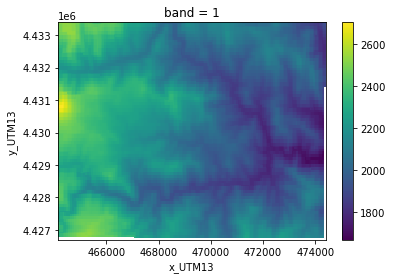

In [12]:
xr.where(reproj_array != -9999, reproj_array, np.nan).plot()

## 3. Create Landlab Grid

In [13]:
from landlab import RasterModelGrid

In [14]:
grid = RasterModelGrid(
    (dim_y_transf, dim_x_transf),
    xy_spacing=target_res,
    xy_of_lower_left=(x_UTM13[0], y_UTM13[0]),
    xy_axis_name=("X UTM13", "Y UTM13"),
    xy_axis_units="m",
)
z = np.ravel(np.flipud(reproj_array.values[0]))
grid.at_node["topographic__elevation"] = z

Close the no data values

In [15]:
grid.status_at_node[np.isclose(z, -9999)] = grid.BC_NODE_IS_CLOSED

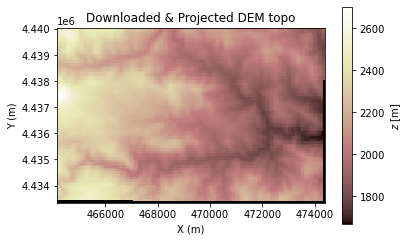

In [16]:
imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Downloaded & Projected DEM topo",
    #     color_for_closed=None,
    colorbar_label="$z$ [m]",
)

## 4. Clip Grid to largest watershed using the FlowAccumulator and a watershed mask

In [17]:
from landlab.components import FlowAccumulator
from landlab.utils import get_watershed_masks_with_area_threshold

C:\Users\sahrendt\Anaconda3\envs\landlab_dev\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Run the FlowAccumulator to determine where flow is being directed and accumulated in the watershed

In [18]:
FlowAccumulator(
    grid, flow_director="D8", depression_finder="DepressionFinderAndRouter"
).run_one_step()

### Create a mask to isolate the largest watershed:
Here we use the get_watershed_mask_with_area_threshhold function: https://landlab.readthedocs.io/en/master/reference/utils/watershed.html#landlab.utils.watershed.get_watershed_masks_with_area_threshold with a critical threshhold as the maximum drainage area. (This will filter out all watersheds draining to an area smaller than this.) 

In [19]:
mask = get_watershed_masks_with_area_threshold(
    grid, grid.at_node["drainage_area"].max()
)

In [20]:
mask

array([-1, -1, -1, ..., -1, -1, -1])

Set all values outside the largest watershed to a nodata value of -9999:

In [21]:
no_dataval = -9999
grid.at_node["topographic__elevation"] = np.where(
    mask != -1, grid.at_node["topographic__elevation"], no_dataval
)

Set the model boundary conditions to 'closed' outside of the watershed

In [22]:
grid.status_at_node[
    np.isclose(grid.at_node["topographic__elevation"], no_dataval)
] = grid.BC_NODE_IS_CLOSED

Visualize clipped DEM:

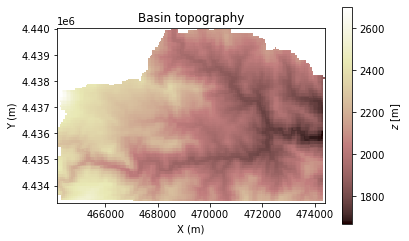

In [23]:
imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)
# plt.scatter(grid.x_of_node[75238], grid.y_of_node[75238])
# plt.scatter(grid.x_of_node[74896], grid.y_of_node[74896])

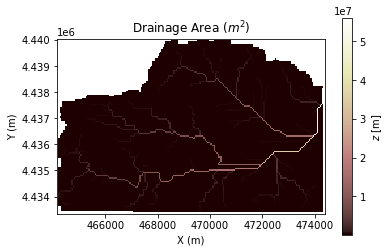

In [25]:
imshow_grid(
    grid,
    "drainage_area",
    plot_name='Drainage Area ($m^2$)',
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)

### Set a watershed boundary condition for your grid

This function uses the minimum elevation node nearest to the nodata values. This DEM has two possible outlet nodes, which can be identified if you run the following code block. An error is thrown that says 'Grid has multiple potential outlet nodes'. Here, we choose the first node in the list of node IDs shown in the error window. (You may want to plot them on your DEM to verify that they make sense as an outlet node--see below). This error may happen when there are a few very low elevation cells.
* Note: this step is important for deliniating the channel. If you find the code is taking a long time to generate the NetworkModelGrid, check which node you set as the boundary condition.

In [27]:
# grid.set_watershed_boundary_condition(
#     'topographic__elevation',
#     nodata_value=-9999,
#     return_outlet_id=True
# )

In [28]:
grid.set_watershed_boundary_condition_outlet_id(
    [10658],
    "topographic__elevation",
)

## 5. Create a NetworkModelGrid on this topography

Now we will generate a network using the default placement of a NetworkModelGrid node for every corresponding RasterModelGrid node. You may want to coarsen this later when you decide what is an acceptable NetworkModelGrid spacing for a NetworkSedimentTransporter model. (i.e. stability). Some notes:

* Be SURE you have a ballpark minimum channel threshhold: this is a drainage area threshhold that sets the upstream drainage area for which you want to truncate your channel network. Start high, and then reduce for a more complex network that extends to higher elevations.
* Be sure you have your outlet node defined
* You can pass information from the RasterModelGrid nodes to the NetworkModelGrid nodes using the 'include' variable if you have other things attached to your RasterModelGrid that would be helpful for the NetworkModelGrid to know (i.e. slope)

In [29]:
from landlab.grid.create_network import (
    AtMostNodes,
    SpacingAtLeast,
    network_grid_from_raster,
    spacing_from_drainage_area,
)
from landlab.plot.graph import plot_nodes, plot_links

In [30]:
network_grid = network_grid_from_raster(
    grid,
    minimum_channel_threshold=5000000,  # upstream drainage area to truncate network, in m^2
    include=["drainage_area", "topographic__elevation"],
)

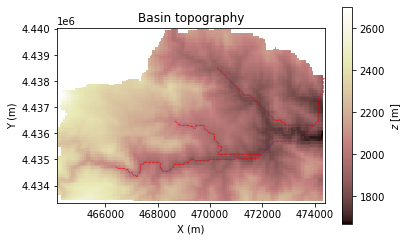

In [31]:
imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)
plot_links(network_grid, with_id=False, as_arrow=False, linewidth=0.05)
plot_nodes(network_grid, with_id=False, markersize=0.2)

### Refine Network using Reducers

Now we will use the Reducer options to reduce the number of nodes on the network. This shows an example where 10 nodes are placed on each segment of the river between bifurcations.

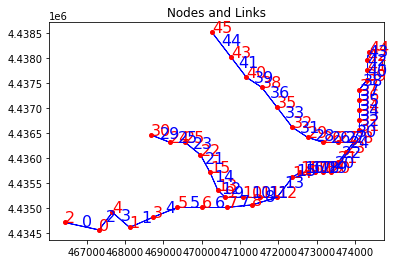

In [32]:
network_grid = network_grid_from_raster(
    grid,
    reducer=AtMostNodes(count=10),
    minimum_channel_threshold=5000000,
    include=["drainage_area", "topographic__elevation"],
)
plot_nodes(network_grid, markersize=4)
plot_links(network_grid, as_arrow=False)
plt.title("Nodes and Links");

Realistically, you may want to reduce your NetworkModelGrid node spacing in the steeper, higher elevation areas of the basin for stability of the NetworkSedimentTransporter model. Here, we show an option to define the network node spacing from an upstream drainage area relation that estimates river width from the Frasson et al. 2019 (GRL) power law relationship:

$W=a*DA^b$

where $W$ is width $DA$ is drainage area and $a$ and $b$ are parameters. The function uses default values for a and b reported in the paper from fitting field data, but you  may want to adjust this depending on your river system. Changing n_widths will adjust node spacing by a certain multiple of local river width.

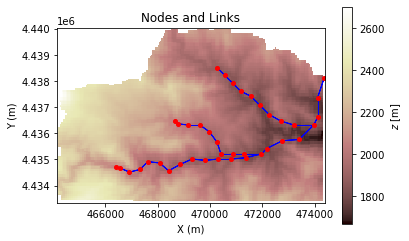

In [33]:
spacing = spacing_from_drainage_area(
    grid.at_node["drainage_area"], a=9.68, b=0.32, n_widths=100
)

network_grid = network_grid_from_raster(
    grid,
    reducer=SpacingAtLeast(grid.xy_of_node, spacing),
    minimum_channel_threshold=5000000,
    include=["drainage_area", "topographic__elevation"],
)

imshow_grid(
    grid,
    "topographic__elevation",
    plot_name="Basin topography",
    color_for_closed=None,
    colorbar_label="$z$ [m]",
)

plot_nodes(network_grid, with_id=False, markersize=4)
plot_links(network_grid, with_id=False, as_arrow=False)
plt.title("Nodes and Links");